# Brain Tumor Detection - VGG19 With CNN-LSTM Architecture

## Import necessary libraries

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout, LSTM, ConvLSTM2D,  Input,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Lambda, Reshape, BatchNormalization, Bidirectional, AveragePooling2D, Flatten
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler, CSVLogger
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc

import keras_tuner as kt

from math import floor

from config import *

## 1. Understanding the data
The dataset contains images of human brain MRI images which are classified into 4 classes: **glioma**, **meningioma**, **no tumor** and **pituitary**.

In [4]:
glioma_images = os.listdir(DATASET_FOLDER + "/glioma")
meningioma_images = os.listdir(DATASET_FOLDER + "/meningioma")
no_tumor_images = os.listdir(DATASET_FOLDER + "/notumor")
pituitary_images = os.listdir(DATASET_FOLDER + "/pituitary")

### Get number of images

In [5]:
print(len(glioma_images), len(meningioma_images), len(no_tumor_images), len(pituitary_images))
NUM_IMAGES = len(glioma_images) + len(meningioma_images) + len(no_tumor_images) + len(pituitary_images)
print(NUM_IMAGES)

120 120 121 120
481


*As there are equal number of samples for each class, there is no class imbalance and class weight is not needed*

### Visualise sample data and sizes
Here we visualise samples from each class with figure sizes labelled

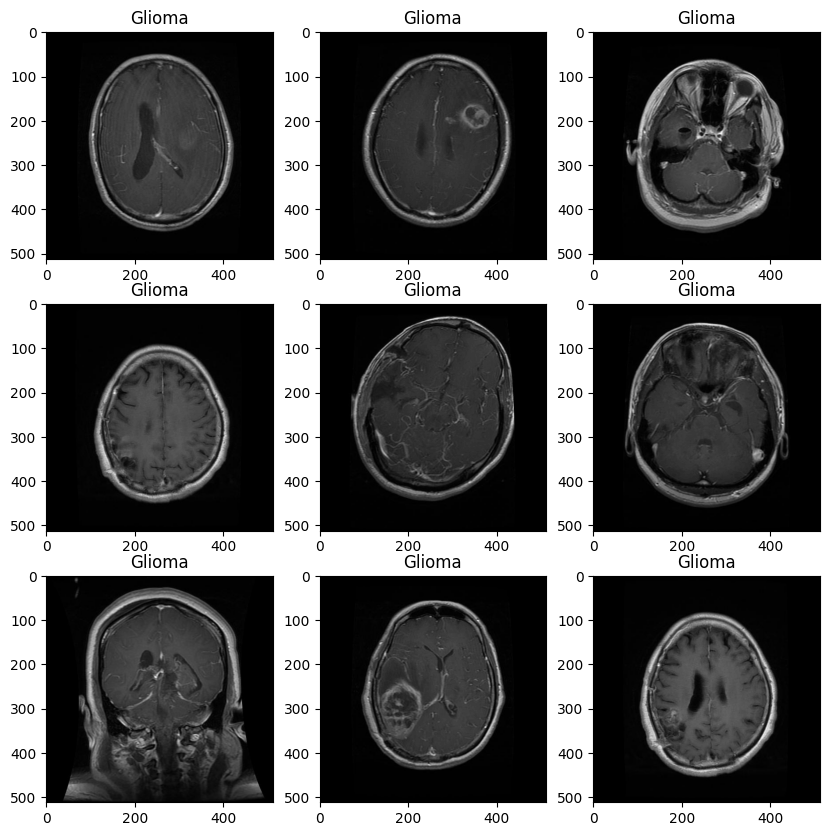

In [6]:
# Glioma
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(DATASET_FOLDER + "/glioma",glioma_images[i])),cmap='gray')
    plt.title("Glioma")
plt.show()

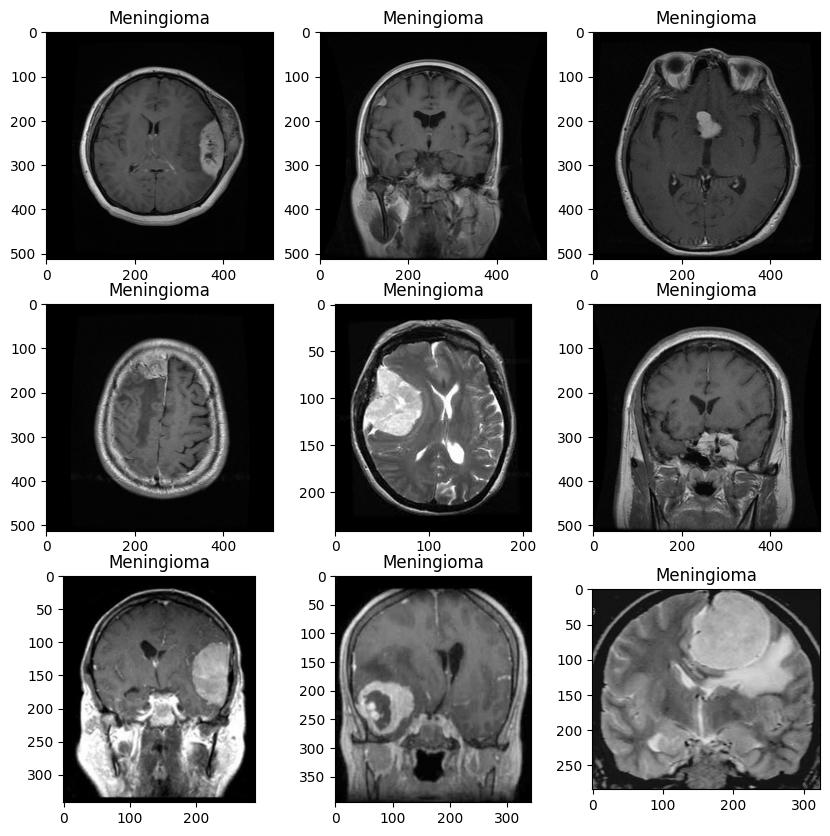

In [7]:
# Meningioma
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(DATASET_FOLDER + "/meningioma",meningioma_images[i])),cmap='gray')
    plt.title("Meningioma")
plt.show()

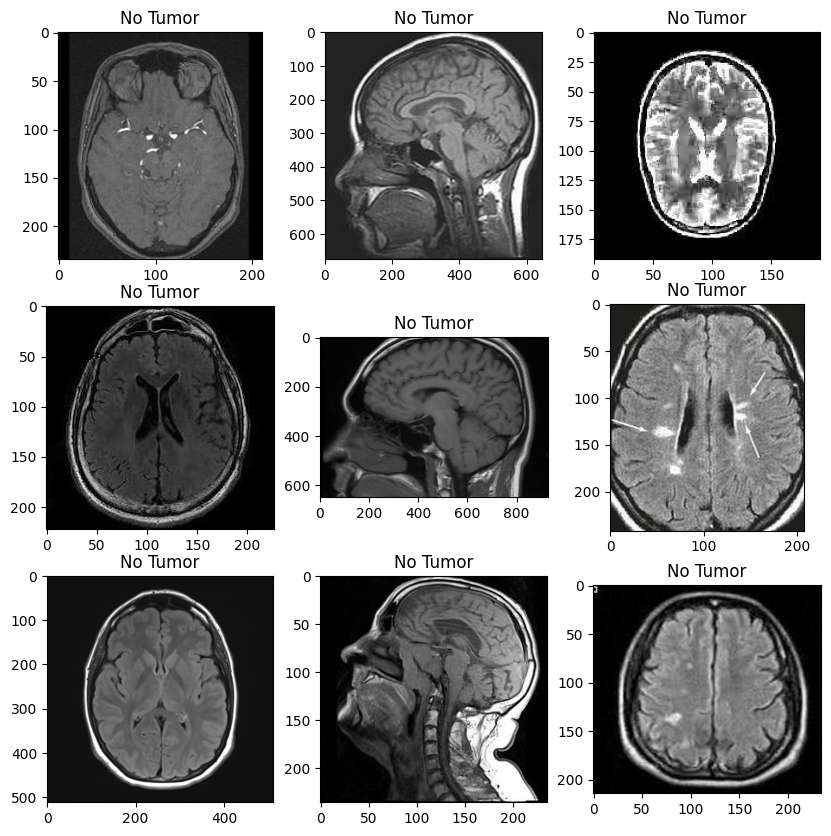

In [8]:
# No tumor
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(DATASET_FOLDER + "/notumor",no_tumor_images[i])),cmap='gray')
    plt.title("No Tumor")
plt.show()

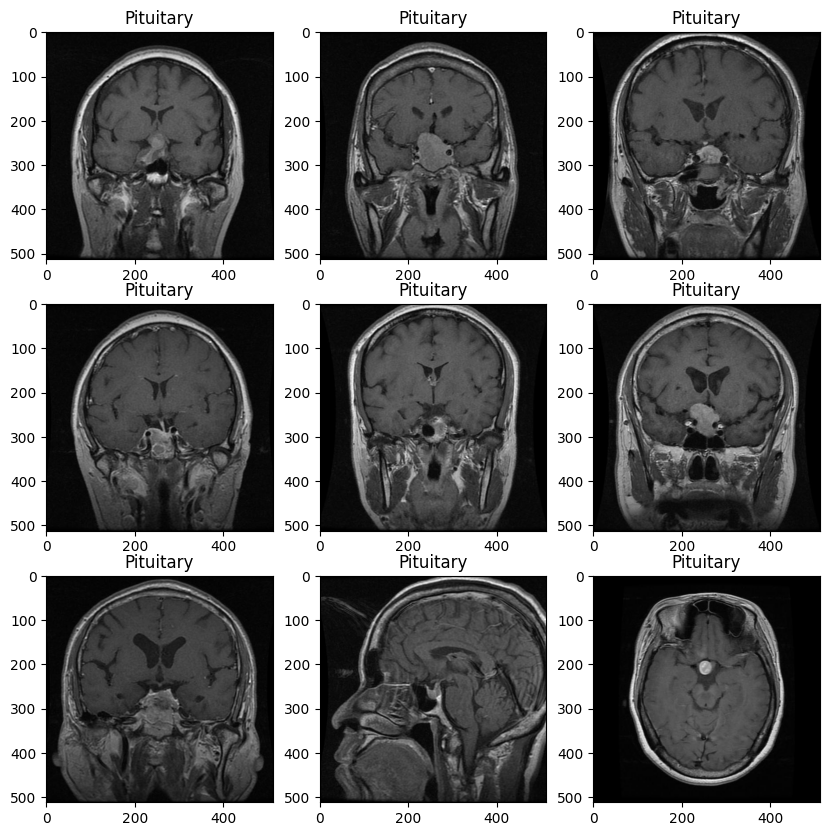

In [9]:
# Pituitary
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(DATASET_FOLDER + "/pituitary",pituitary_images[i])),cmap='gray')
    plt.title("Pituitary")
plt.show()

*Since there are differing sizes between the images, it is important to scale the images to a common size*



# 2. Data preparation
*After inspection of data, data is firstly split into train test folders with a predefined ratio of `0.3`*

In [10]:
import os
import shutil
import random

# Create train and test directories within each class label folder
for label_folder in os.listdir(DATASET_FOLDER):
    if os.path.isdir(os.path.join(DATASET_FOLDER, label_folder)):
        shutil.rmtree(os.path.join(TRAIN_FOLDER, label_folder), ignore_errors=True)
        shutil.rmtree(os.path.join(TEST_FOLDER, label_folder), ignore_errors=True)
        os.makedirs(os.path.join(TRAIN_FOLDER, label_folder), exist_ok=True)
        os.makedirs(os.path.join(TEST_FOLDER, label_folder), exist_ok=True)

        # Get list of images in the current label folder
        images = os.listdir(os.path.join(DATASET_FOLDER, label_folder))
        print(f"Found {len(images)} images in {label_folder} folder.")

        # Copy all images to train folder
        for image in images:
            shutil.copy(
                os.path.join(DATASET_FOLDER, label_folder, image),
                os.path.join(TRAIN_FOLDER, label_folder, image)
            )
        
        print(f"Copied {len(images)} images to train folder.")

        # Calculate number of images to move to test folder
        num_train_images = len(images)
        num_test_images = int(num_train_images * TEST_SIZE)
        print(f"Moving {num_test_images} images to test folder.")

        # Randomly select images for the test set
        test_images = random.sample(images, num_test_images)

        # Move the selected test images to the test folder
        for image in test_images:
            shutil.move(
                os.path.join(TRAIN_FOLDER, label_folder, image),
                os.path.join(TEST_FOLDER, label_folder, image)
            )
        print(f"Moved {num_test_images} images to test folder.\n")
        
print("Dataset splitting completed successfully.")

Found 120 images in pituitary folder.
Copied 120 images to train folder.
Moving 36 images to test folder.
Moved 36 images to test folder.

Found 121 images in notumor folder.
Copied 121 images to train folder.
Moving 36 images to test folder.
Moved 36 images to test folder.

Found 120 images in glioma folder.
Copied 120 images to train folder.
Moving 36 images to test folder.
Moved 36 images to test folder.

Found 120 images in meningioma folder.
Copied 120 images to train folder.
Moving 36 images to test folder.
Moved 36 images to test folder.

Dataset splitting completed successfully.


### Data augmentation
Previously, it was observed that rescaling was necessary. As a result, the training dataset is resized using `flow_from_directory` and augmented using `ImageDataGenerator`, which provides a way to augment images in real-time during the model training process to further enhance generalization.

In [11]:
# Data Augmentation
# Define the data augmentation parameters for the training dataset
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='nearest'
)

# Define the data augmentation parameters for the test dataset
test_datagen = ImageDataGenerator(rescale = 1./255)

# Create the training and test datasets
train_dataset = train_datagen.flow_from_directory(TRAIN_FOLDER,
                                                 target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

test_dataset = test_datagen.flow_from_directory(TEST_FOLDER,
                                                 target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                 shuffle=True)



Found 336 images belonging to 4 classes.
Found 144 images belonging to 4 classes.


## Visualize and verify class indicies

In [12]:
train_dataset.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [13]:
test_dataset.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

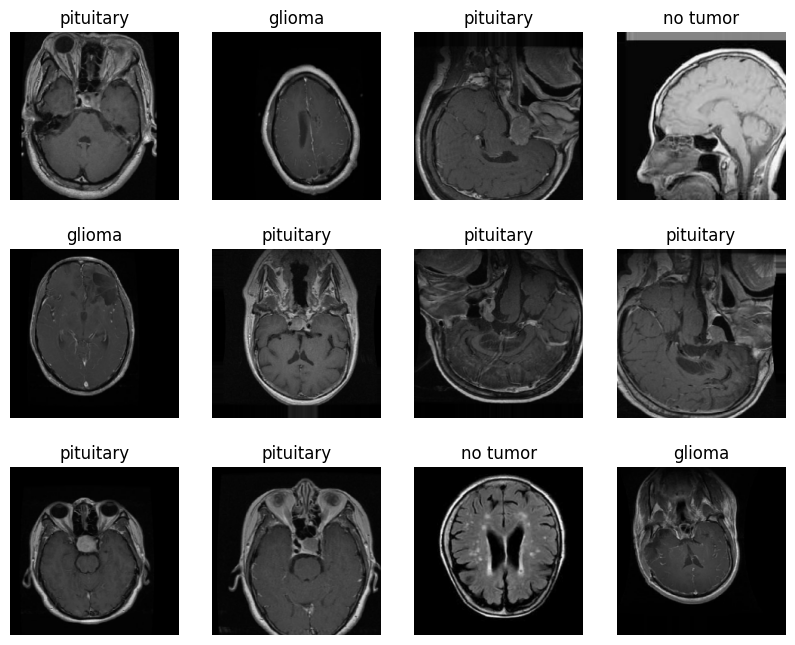

In [14]:
labels = ['glioma', 'meningioma', 'no tumor', 'pituitary']

sample_data = train_dataset.__getitem__(1)[0] 
sample_label = train_dataset.__getitem__(1)[1] 

plt.figure(figsize=(10,8))

# Display 12 images from the training dataset
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    plt.title(labels[np.argmax(sample_label[i])])

# 3. Modelling
Data is ready for training and testing.\
The model utilizes a pre-trained `VGG19` model with ImageNet weights as a feature extractor. A Long Short-Term Memory (LSTM) layer is then attached, followed by two fully connected layers. Finally, the model produces a softmax output with four units for classification.
The following hyperparameters are finetuned:
1. Activation function choice for `LSTM` layer - `lstm_activation`: `relu`, `tanh`
2. Activation function choice for first fully connected layer -  `fc1_activation`: `relu`, `tanh`
2. Activation function choice for second fully connected layer - `fc2_activation` : `relu`, `tanh`
3. Number of units in first fully connected layer - `fc1_units`: 64 to 512, step of 64
4. Number of units in second fully connected layer - `fc2_units`: 64 to 512, step of 64
5. Whether to drop out or not - `use_dropout`: `yes`, `no`
6. Dropout rate - `dropout_rate`: 0.1 to 0.5, step of 0.1
7. Learning rate - `lr`: 1e-4 to 1e-2, log sampling

In [15]:
def build_model(hp):
  
  
	# Input layer
  input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

	# Base VGG19 model as a feature extractor
  base_model = VGG19(weights="imagenet", include_top=False, input_tensor=input_layer)

	# Freeze the base model
  for layer in base_model.layers:
      layer.trainable = False
  x = base_model.output
	
	# LSTM layer
  x = Reshape((49, 512))(x)
  x = LSTM(512, activation=hp.Choice("lstm_activation", ["relu", "tanh"]), return_sequences=True, trainable=False)(x)
  x = BatchNormalization()(x)

	# FC layer
  x = Flatten(name="flatten")(x)

	# FC1 layer
  x = Dense(units=hp.Int("fc1_units", min_value=64, max_value=512, step=64), activation=hp.Choice("fc1_activation", ["relu", "tanh"]))(x)
  x = BatchNormalization()(x)

	# FC2 layer
  x = Dense(units=hp.Int("fc2_units", min_value=64, max_value=512, step=64), activation=hp.Choice("fc2_activation", ["relu", "tanh"]))(x)
  x = BatchNormalization()(x)
	
	# Dropout layer
  if hp.Choice("use_dropout", ["Yes", "No"]) == "Yes":
      x = Dropout(rate=hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1))(x)
  
	# Output layer
  output = Dense(units=4, activation='softmax')(x)

  model = Model(inputs=input_layer, outputs=output)

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")), metrics=["accuracy"])

  return model

# Test if the model builds successfully
build_model(kt.HyperParameters())

2024-06-18 21:09:19.703571: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2024-06-18 21:09:19.703593: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-18 21:09:19.703604: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-18 21:09:19.703787: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-18 21:09:19.703804: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<Functional name=functional_1, built=True>

In [16]:
import datetime
decay_rate = 0.95
decay_step = 1
INIT_LR = 1e-3

# Checkpoint callback
checkpoint = ModelCheckpoint(filepath='best_model.weights.h5', 
                        	 monitor='val_accuracy',
                           	 mode='max',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True
						),

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## Initialise tuner
Here we initialise the `keras-tuner` which will search for the optimal hyperparameters to use for model training

In [17]:
# Define the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=50,
    				 directory="hyperparameter-search",
    				 project_name="brain-tumor-classification",
)

# Search for the best hyperparameters
tuner.search(train_dataset, epochs=50, validation_data=test_dataset)

Reloading Tuner from hyperparameter-search/brain-tumor-classification/tuner0.json


In [18]:
# Get the optimal hyperparameters after the search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(f"LSTM Activation: {best_hps.get('lstm_activation')}")
print(f"FC1 Units: {best_hps.get('fc1_units')}")
print(f"FC1 Activation: {best_hps.get('fc1_activation')}")
print(f"FC2 Units: {best_hps.get('fc2_units')}")
print(f"FC2 Activation: {best_hps.get('fc2_activation')}")
print(f"Use Dropout: {best_hps.get('use_dropout')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Learning Rate: {best_hps.get('lr')}")

Best Hyperparameters:
LSTM Activation: tanh
FC1 Units: 64
FC1 Activation: tanh
FC2 Units: 256
FC2 Activation: relu
Use Dropout: No
Dropout Rate: 0.5
Learning Rate: 0.00022762343549467492


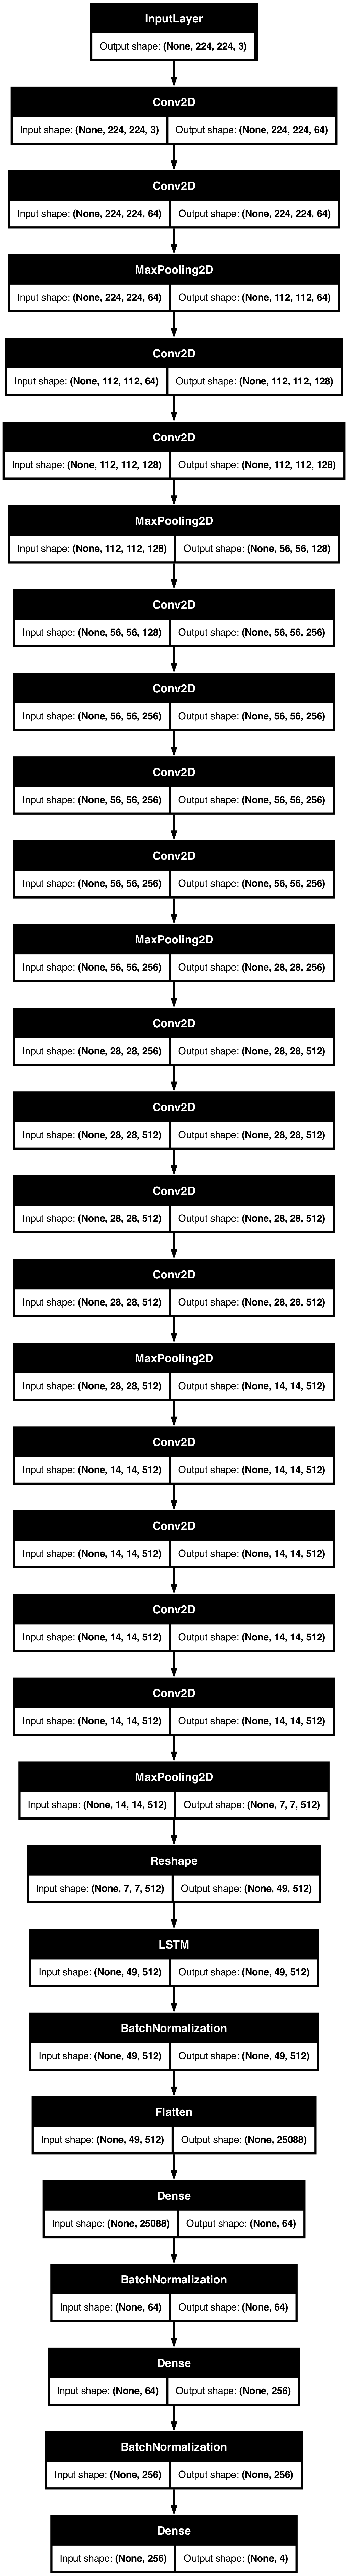

In [19]:
from tensorflow.keras.utils import plot_model

# Build the model with the best hyperparameters
model = build_model(best_hps)

plot_model(model, show_shapes=True, to_file='model.png')

In [20]:
# Train the model
history = model.fit(train_dataset, 
					epochs=100, 
					validation_data=test_dataset, 
					callbacks=[checkpoint, tensorboard_callback]
				)

Epoch 1/100


2024-06-18 21:09:24.901209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/lionel/Documents/School/Year_2/Tri_2.3/CSC3109_ML/CSC3109-ML/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.4584 - loss: 1.4500
Epoch 1: val_accuracy improved from -inf to 0.38194, saving model to best_model.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 849ms/step - accuracy: 0.4636 - loss: 1.4344 - val_accuracy: 0.3819 - val_loss: 1.2573
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.6609 - loss: 0.8201
Epoch 2: val_accuracy did not improve from 0.38194
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 771ms/step - accuracy: 0.6627 - loss: 0.8171 - val_accuracy: 0.3819 - val_loss: 1.2336
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.7180 - loss: 0.6825
Epoch 3: val_accuracy improved from 0.38194 to 0.46528, saving model to best_model.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 791ms/step - accuracy: 0.7189 - loss: 0.6828 - val_accuracy: 0.4653 - val_loss: 1.2059
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.7469 - loss: 0.6942
Epoch 4: val_accuracy improved from 0.46528 to 0.51389, saving model to best

In [21]:
# Export model
model.save(MODEL_FILE)
print(f"Model saved to {MODEL_FILE}")

Model saved to models/vgg19_model.keras


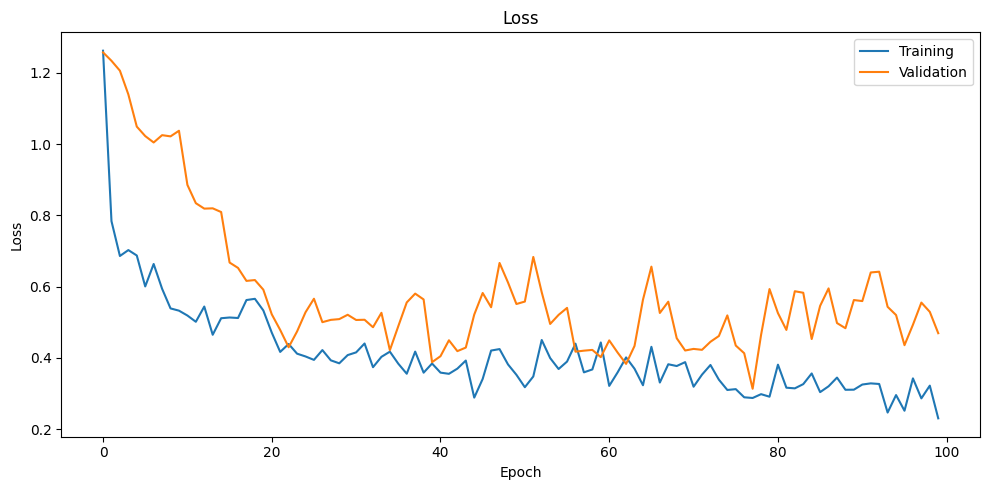

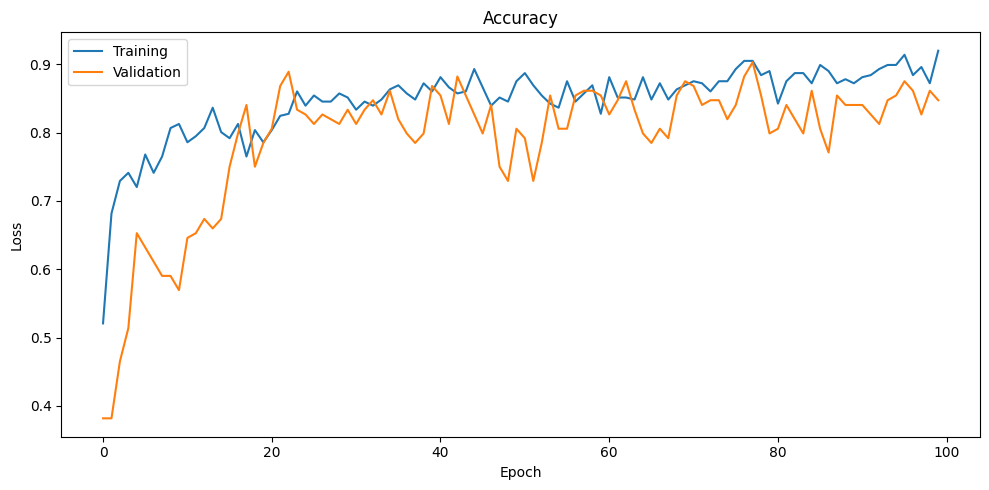

In [22]:
def display_training_curves(training, validation, title):
	plt.figure(figsize=(10, 5))
	
	plt.plot(training)
	plt.plot(validation)
	plt.title(title)
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	plt.legend(['Training', 'Validation'])
	
	plt.tight_layout()
	plt.show()

# Plot loss
display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss')

# Plot accuracy
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

## 4. Model Evaluation

## Evaluation

In [23]:
# Load the best model
model.load_weights('best_model.weights.h5')

# Evaluate the model on the test dataset
_, accuracy = model.evaluate(test_dataset)
print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 388ms/step - accuracy: 0.9008 - loss: 0.3092
Validation accuracy: 90.28%


## Confusion Matrix

In [24]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(20, 20), text_size=15, norm=False, savefig=False):

  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  ax.grid(False)

  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

## K-Fold Cross-Validation

In [25]:
import pickle

# Load best_hp from pickle
with open('best_hp.pkl', 'rb') as f:
		best_hps = pickle.load(f)
  
print("Best Hyperparameters:")
print(f"LSTM Activation: {best_hps.get('lstm_activation')}")
print(f"FC1 Units: {best_hps.get('fc1_units')}")
print(f"FC1 Activation: {best_hps.get('fc1_activation')}")
print(f"FC2 Units: {best_hps.get('fc2_units')}")
print(f"FC2 Activation: {best_hps.get('fc2_activation')}")
print(f"Use Dropout: {best_hps.get('use_dropout')}")
print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Learning Rate: {best_hps.get('lr')}")

Best Hyperparameters:
LSTM Activation: tanh
FC1 Units: 64
FC1 Activation: tanh
FC2 Units: 256
FC2 Activation: relu
Use Dropout: No
Dropout Rate: 0.5
Learning Rate: 0.00022762343549467492


In [26]:
""" K-Fold Cross-Validation """
from sklearn.model_selection import StratifiedKFold, KFold
from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras.utils import to_categorical

# Load dataset without validation split
dataset = image_dataset_from_directory(
    DATASET_FOLDER,
    shuffle=True,
    seed=RANDOM_STATE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Convert dataset to numpy arrays for k-fold splitting
images = []
labels = []
for image, label in dataset:
    images.append(image.numpy())
    labels.append(label.numpy())
images = np.concatenate(images)
labels = np.concatenate(labels)

labels = to_categorical(labels)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialise lists to store results
list_kf_results = []
list_skf_results = []

print("K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in kf.split(images, labels):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
		
    # Create TensorFlow datasets
    train_ds = Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = Dataset.from_tensor_slices((val_images, val_labels))
    
    # Prefetch datasets
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    
    # Build the model
    model = build_model(best_hps)

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=100, batch_size=32, verbose=0)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds)
    val_loss, val_accuracy = model.evaluate(val_ds)
    
    # Save results
    list_kf_results.append({"train_loss": train_loss, "train_accuracy": train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy, "history": history})
    
    print("Fold Index", fold_no)
    print(f"~Training Dataset~\nAccuracy: {train_accuracy}, Loss: {train_loss}")
    print(f"~Validation Dataset~\nAccuracy: {val_accuracy}, Loss: {val_loss}", end="\n\n")
    
    # Increment fold number
    fold_no += 1

Found 480 files belonging to 4 classes.


2024-06-18 21:24:32.994333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


K-Fold Cross-Validation
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 443ms/step - accuracy: 1.0000 - loss: 2.4550e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 475ms/step - accuracy: 0.7578 - loss: 0.8410
Fold Index 0
~Training Dataset~
Accuracy: 1.0, Loss: 0.0003006996994372457
~Validation Dataset~
Accuracy: 0.75, Loss: 0.9080742001533508

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 460ms/step - accuracy: 1.0000 - loss: 3.4092e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 482ms/step - accuracy: 0.9036 - loss: 0.3294
Fold Index 1
~Training Dataset~
Accuracy: 1.0, Loss: 0.0003963013587053865
~Validation Dataset~
Accuracy: 0.8854166865348816, Loss: 0.344442218542099

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - accuracy: 1.0000 - loss: 3.0453e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 454ms/step - accuracy: 0.8568 - loss: 0.4448
Fold Index 2
~Training Dataset~
Accuracy: 1.0, Loss: 0.0003757701488211751
~Validation Dataset~
Accuracy: 0.8854166865348816, Loss: 0.37272703647613525

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 471ms/step - accuracy: 1.0000 - loss: 3.8728e-04